In [1]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import factorial
%matplotlib inline 

### Function Library:

In [2]:
def runAlgo(algo, df, nneigh= 13, coefs=0):
    if algo =='KNN':
        mypipeline = Pipeline([
            ('masterAlg', KNeighborsClassifier(n_neighbors = nneigh))
        ])
    elif algo == 'LR':
        mypipeline = Pipeline([
            ('masterAlg', LogisticRegression())
        ])
    
    dftrain, dftest = df[:len(df)/2],df[len(df)/2:]
    X_train, y_train = dftrain.iloc[:,0:len(df.columns)-1],dftrain.target
    X_test, y_test = dftest.iloc[:,0:len(df.columns)-1],dftest.target
    
    mypipeline.fit(X_train,y_train)
    y_pred = mypipeline.predict(X_test) 
    if coefs==1:
        return mypipeline.get_params('masterAlg')['masterAlg'].coef_
    else:
        performanceOutput = perfReport(y_test,y_pred) 
    return performanceOutput

In [3]:
def perfReport(ytest,ypred):
    dfcm = pd.DataFrame(data=confusion_matrix(ytest, ypred))
    indices = ['0','1','2','3','4','5','6','7','8','9','Average']
    columns = ['Precision','Recall','F1 Score']
    dfperf = pd.DataFrame(index= indices,columns = columns)
    for i in range(0,len(dfcm)):
        tp = dfcm.iloc[i,i]
        fp = int(dfcm[i].sum())-tp
        fn = int(dfcm.iloc[i].sum())-tp
        precision = float(tp)/(tp+fp)
        recall = float(tp)/(tp+fn)
        f1 = float(2)/(1/precision + 1/recall)
        dfperf.iloc[i,0] = precision
        dfperf.iloc[i,1] = recall
        dfperf.iloc[i,2] = f1
    avgs = prfs(ytest,ypred,average='weighted')
    dfperf.Precision[10] = avgs[0]
    dfperf.Recall[10] = avgs[1]
    dfperf['F1 Score'][10] = avgs[2]
    return dfperf

In [4]:
def optimalKNNtable(df, numneigh=50):
    testneighbors = [i for i in range(3,numneigh,2)]
    frames = [runAlgo('KNN',df,nneigh=j) for j in testneighbors]
    results = pd.concat(frames,keys=testneighbors)
    
    cols = [i for i in range(0,10)]
    cols.append('Average')
    table = pd.DataFrame(index=testneighbors,columns=cols)    
    for i in cols:
        dig=i
        for j in testneighbors:
            table[dig][j] = results.loc[j,str(dig)]['F1 Score']
    return table

In [5]:
def bestneighbors(optimalKNNoutput):
    return optimalKNNoutput.Average.idxmax()

In [6]:
def plotneighbors(df):
    figure(figsize=(12,7))
    for i in range(0,11):
        plt.plot(df.index,df.iloc[:,i])
    plt.title('F1 Score for Each Digit vs KNN # of Neighbors')
    plt.xlabel('Number of Neighbors') 
    plt.ylabel('F1 Score')
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.xticks(np.arange(3,49,2))
    return

In [7]:
def bestpixelest(df):
    lrcoefs = runAlgo('LR',df,coefs=1)
    dfcoef = pd.DataFrame(data=lrcoefs,columns=df.columns.drop('target'))

    sums = np.array([])
    for j in range(0,len(dfcoef.columns)):
        sums = np.append(sums,abs(dfcoef.iloc[:,j]).sum())
    sums = sums.reshape(1,len(sums))
    sumrow = pd.DataFrame(data=sums,index=['abs(sums)'],columns=dfcoef.columns)
    dfcoef = dfcoef.append(sumrow,ignore_index=False)
    
    pix = []
    for i in dfcoef.loc['abs(sums)'].sort_values(ascending=False).index[0:8]:
        pix.append(i)
    pix.append('target')    
    return pix

In [8]:
def bestpixelarray(df, num=8):
    bestpixels = []    
    for i in range(0,num):
        pixel = bestpixelest(df)
        bestpixels.append(pixel)
        df = df[df.columns.drop(bestpixels[i])]
    return bestpixels

### Setting up the initial dataframe

In [9]:
from sklearn.datasets import load_digits

digits = load_digits()
df = pd.DataFrame(data = np.c_[digits.data,digits.target])
df = df.rename(columns={64:'target'})

#### Convert every pixel to 1 if it contains a signal, 0 otherwise

In [11]:
df1 = df.copy()
df1.iloc[:,0:64] = df1.iloc[:,0:64]>=1

In [12]:
df1shuff = df1.sample(frac=1)

##### Logisitic Regression

In [13]:
lr1test = runAlgo('LR',df1shuff)
lr1worstdig = lr1test['F1 Score'].idxmin()
lr1test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.988636,0.803922,0.942529,0.936842,0.952381,0.921348,0.89011,0.941176,0.71,0.884615,0.896551
Recall,0.977528,0.796117,0.931818,0.816514,0.941176,0.901099,0.987805,0.941176,0.806818,0.873418,0.893215
F1 Score,0.983051,0.8,0.937143,0.872549,0.946746,0.911111,0.936416,0.941176,0.755319,0.878981,0.893822


In [14]:
print '\tWorst performing digit for transformation #1 with LR:',lr1worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(lr1test['F1 Score'][lr1worstdig])

	Worst performing digit for transformation #1 with LR: 8
	F1 Score of worst digit: 0.76


##### KNN

In [15]:
knn1neighbortable = optimalKNNtable(df1shuff)

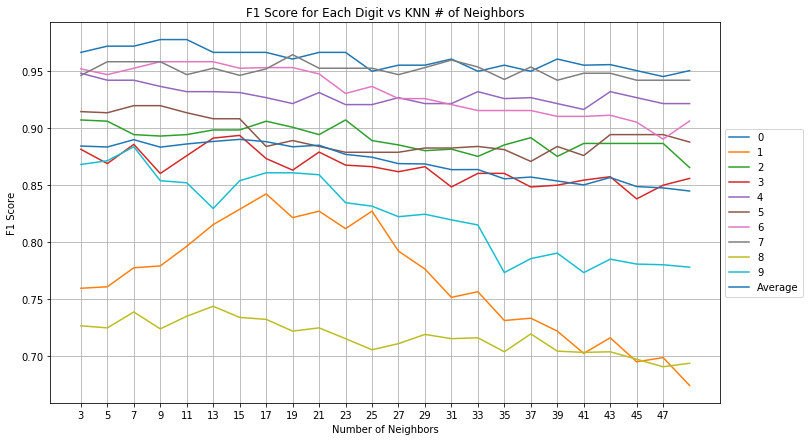

In [16]:
plotneighbors(knn1neighbortable)

In [17]:
knn1bestneighbor = bestneighbors(knn1neighbortable)
print '#neighbors generating best average F1 Score: {0:,}'.format(knn1bestneighbor)

#neighbors generating best average F1 Score: 15


In [18]:
knn1test = runAlgo('KNN', df1shuff, nneigh=knn1bestneighbor)
knn1worstdig = knn1test['F1 Score'].idxmin()
knn1test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.966292,0.813084,0.949367,1,0.910112,0.951807,0.930233,0.963415,0.657658,0.823529,0.898073
Recall,0.966292,0.84466,0.852273,0.807339,0.952941,0.868132,0.97561,0.929412,0.829545,0.886076,0.887653
F1 Score,0.966292,0.828571,0.898204,0.893401,0.931034,0.908046,0.952381,0.946108,0.733668,0.853659,0.889935


In [19]:
print '\tWorst performing digit for transformation #1 with KNN:',knn1worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(knn1test['F1 Score'][knn1worstdig])

	Worst performing digit for transformation #1 with KNN: 8
	F1 Score of worst digit: 0.73


### Adding the pixels by row and by column to covert 8x8 features into 8+8 features

In [20]:
columns = []
for i in range(0,8):
    columns.append('r'+str(i))
    columns.append('c'+str(i))
columns.sort()
columns.append('target')

In [21]:
df2 = pd.DataFrame(columns = columns)

In [22]:
for i in range(0,len(digits.images)):
    digit = digits.images[i]
    rowsums = []
    colsums = []
    for j in range(0,8):
        rowsum=rowsums.append(digit[j].sum())
        colsum=colsums.append(digit[:,j].sum())
    newrow = np.hstack([colsums,rowsums,[0]])
    tempdf = pd.DataFrame(data=newrow.reshape(1,17),columns=columns)
    df2 = df2.append(tempdf,ignore_index=True)
df2.target = df.target

In [23]:
df2shuff = df2.sample(frac=1)

##### Logistic Regression

In [24]:
lr2test = runAlgo('LR',df2shuff)
lr2worstdig = lr2test['F1 Score'].idxmin()
lr2test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.929412,0.788889,0.894737,0.852632,0.951807,0.88764,0.947917,0.948052,0.752475,0.875,0.880415
Recall,0.9875,0.755319,0.923913,0.89011,0.929412,0.88764,0.947917,0.829545,0.76,0.916667,0.879867
F1 Score,0.957576,0.771739,0.909091,0.870968,0.940476,0.88764,0.947917,0.884848,0.756219,0.895349,0.879513


In [25]:
print '\tWorst performing digit for transformation #2 with LR:',lr2worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(lr2test['F1 Score'][lr2worstdig])

	Worst performing digit for transformation #2 with LR: 8
	F1 Score of worst digit: 0.76


##### KNN

In [26]:
knn2neighbortable = optimalKNNtable(df2shuff)

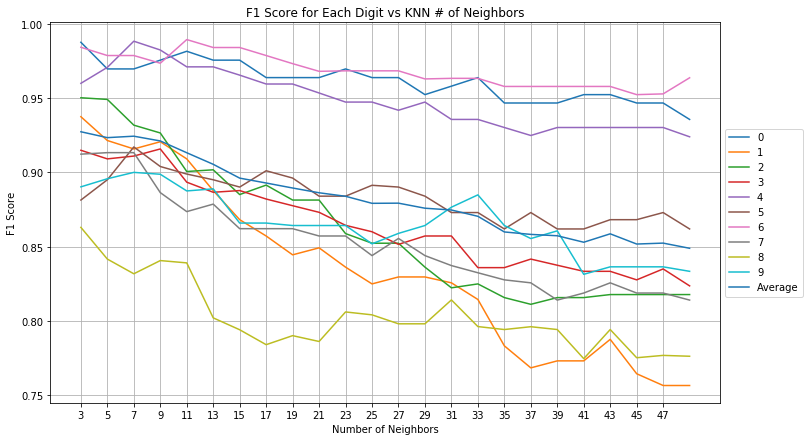

In [27]:
plotneighbors(knn2neighbortable)

In [28]:
knn2bestneighbor = bestneighbors(knn2neighbortable)
print '#neighbors generating best average F1 Score: {0:,}'.format(knn2bestneighbor)

#neighbors generating best average F1 Score: 3


In [29]:
knn2test = runAlgo('KNN', df2shuff, nneigh=knn2bestneighbor)
knn2worstdig = knn1test['F1 Score'].idxmin()
knn2test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.97561,0.918367,0.966292,0.886598,0.933333,0.886364,0.989474,0.939759,0.876289,0.9125,0.927855
Recall,1,0.957447,0.934783,0.945055,0.988235,0.876404,0.979167,0.886364,0.85,0.869048,0.927697
F1 Score,0.987654,0.9375,0.950276,0.914894,0.96,0.881356,0.984293,0.912281,0.862944,0.890244,0.927371


In [30]:
print '\tWorst performing digit for transformation #2 with KNN:',knn2worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(knn2test['F1 Score'][knn2worstdig])

	Worst performing digit for transformation #2 with KNN: 8
	F1 Score of worst digit: 0.86


### Using a random subset of 8 pixels from within the image

Testing the pixels in an open-edge square near the center of the image. When you look at each image as an 8x8 matrix these would be the indices: (2,3),(2,4),(3,2),(3,5),(4,2),(4,5),(5,3),(5,4). The assumption being tested is that important pixels may be near the center of the image. 

In [67]:
test = df.copy()
test = test.sample(frac=1)
test1 = test[subsetpix]

In [31]:
subsetpix = [19,20,26,29,34,37,43,44]
subsetpix.append('target')

In [32]:
df3 = df.copy()
df3 = df3[subsetpix]
df3shuff = df3.sample(frac=1)

##### Logistic Regression

In [68]:
lr3test = runAlgo('LR',test1)
lr3worstdig = lr3test['F1 Score'].idxmin()
lr3test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.704082,0.526316,0.719101,0.836538,0.78,0.653846,0.72381,0.7625,0.717949,0.684783,0.713474
Recall,0.775281,0.75,0.719101,0.887755,0.8125,0.5,0.873563,0.753086,0.294737,0.768293,0.708565
F1 Score,0.737968,0.618557,0.719101,0.861386,0.795918,0.566667,0.791667,0.757764,0.41791,0.724138,0.697578


In [34]:
print '\tWorst performing digit for transformation #3 with LR:',lr3worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(lr3test['F1 Score'][lr3worstdig])

	Worst performing digit for transformation #3 with LR: 8
	F1 Score of worst digit: 0.47


##### KNN

In [35]:
knn3neighbortable = optimalKNNtable(df3shuff)

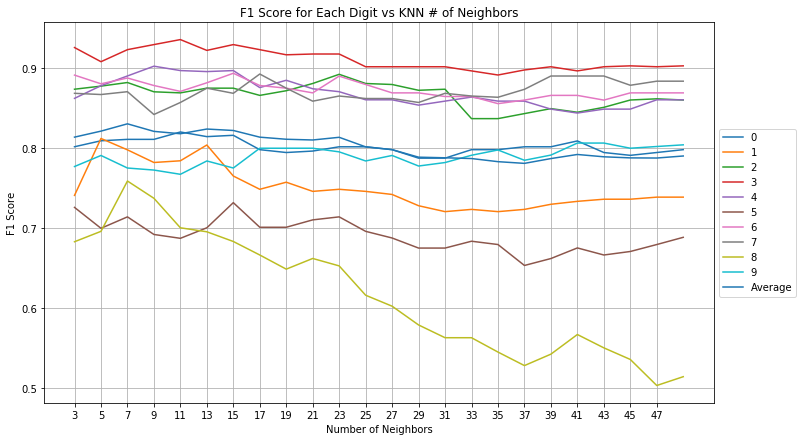

In [36]:
plotneighbors(knn3neighbortable)

In [37]:
knn3bestneighbor = bestneighbors(knn3neighbortable)
print '#neighbors generating best average F1 Score: {0:,}'.format(knn3bestneighbor)

#neighbors generating best average F1 Score: 7


In [69]:
knn3test = runAlgo('KNN', test1, nneigh=knn3bestneighbor)
knn3worstdig = knn1test['F1 Score'].idxmin()
knn3test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.722222,0.69697,0.752294,0.913043,0.87,0.78481,0.849462,0.8625,0.873016,0.802632,0.814857
Recall,0.876404,0.8625,0.921348,0.857143,0.90625,0.607843,0.908046,0.851852,0.578947,0.743902,0.807564
F1 Score,0.791878,0.77095,0.828283,0.884211,0.887755,0.685083,0.877778,0.857143,0.696203,0.772152,0.80409


In [39]:
print '\tWorst performing digit for transformation #2 with KNN:',knn3worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(knn2test['F1 Score'][knn3worstdig])

	Worst performing digit for transformation #2 with KNN: 8
	F1 Score of worst digit: 0.86


### Analysis questions

##### If you wanted to try all combinations of 8 pixels, how many combinations would you have to try? 

In [40]:
combos = factorial(64)/(factorial(64-8)*factorial(8))
print'Testing all combinations requires {0:,} combinations'.format(combos)

Testing all combinations requires 4,426,165,368 combinations


##### If you wanted to know which subset of 8 pixels results in the best classification, without trying all possible combinations, which strategy would you suggest? 

I would use logistic regression on the data for each digit and identify the pixel with the highest predictive power by looking at the regression coefficients and picking the one with the maximum summed value when classifying across all digits. I would store this pixel separately in a list while simultaneously removing it from the original data, and rerun the algorithm to identify the pixel with next highest average predictive power in the absence of the orginal pixel. I would do this 8 times until I had the pixels stored which have the highest average predictive power.

##### How may times do you have to run the classifier in your proposed strategy? Implement your strategy. 

I would have to run the classifier 8 times in my proposed strategy, once for each pixel that is identified with the highest predictive power. 

In [41]:
df4shuff = df.sample(frac=1)

In [42]:
pix=bestpixelest(df4shuff)

In [43]:
df4shuff = pd.DataFrame(data=df4shuff[pix],columns=pix)

Logistic Regression:

In [65]:
lr4test = runAlgo('LR',test)
lr4worstdig = lr4test['F1 Score'].idxmin()
lr4test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,0.988095,0.883495,0.975,0.920792,1,0.955056,0.989247,0.974026,0.911111,0.933333,0.951683
Recall,1,0.947917,0.975,0.939394,0.958333,0.944444,0.989247,0.974026,0.891304,0.903226,0.951057
F1 Score,0.994012,0.914573,0.975,0.93,0.978723,0.949721,0.989247,0.974026,0.901099,0.918033,0.951148


In [45]:
print '\tWorst performing digit for transformation #4 with LR:',lr4worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(lr3test['F1 Score'][lr4worstdig])

	Worst performing digit for transformation #4 with LR: 1
	F1 Score of worst digit: 0.69


KNN:

In [57]:
knn4neighbortable = optimalKNNtable(df4shuff)

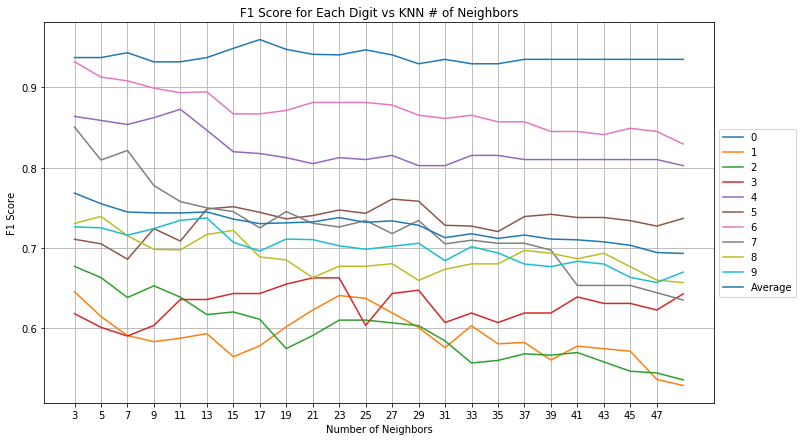

In [58]:
plotneighbors(knn4neighbortable)

In [54]:
knn4bestneighbor = bestneighbors(knn3neighbortable)
print '#neighbors generating best average F1 Score: {0:,}'.format(knn4bestneighbor)

#neighbors generating best average F1 Score: 7


In [66]:
knn4test = runAlgo('KNN', test, nneigh=knn4bestneighbor)
knn4worstdig = knn4test['F1 Score'].idxmin()
knn4test.transpose()

,0,1,2,3,4,5,6,7,8,9,Average
Precision,1,0.950495,1,0.969388,1,0.967033,0.989362,0.916667,0.987952,0.967033,0.975161
Recall,1,1,0.9875,0.959596,0.989583,0.977778,1,1,0.891304,0.946237,0.974416
F1 Score,1,0.974619,0.993711,0.964467,0.994764,0.972376,0.994652,0.956522,0.937143,0.956522,0.974285


In [50]:
print '\tWorst performing digit for transformation #2 with KNN:',knn4worstdig
print '\tF1 Score of worst digit: {0:.2}'.format(knn4test['F1 Score'][knn4worstdig])

	Worst performing digit for transformation #2 with KNN: 3
	F1 Score of worst digit: 0.62


###### Comments on model above:

Several variations of the model were tested such as taking the exponential of the logistic coefficients and calculating their sum, their variance, or their mean for each pixel. Also tested were variations where when a pixel with high predictive power was selected, and the neighboring pixels (variations included all neighbors in a surrounding square, only those directly above or to the sides, and those on diagonals) were also removed in order to avoid clustering of high value pixels that only helped predict certain digits and created a very biased model. None of these performed as consistently well as the model above which simply looks at the sum of the logistic coefficients for each pixel. This typically performs in the 70-83% range for overall F1 score. Very interestingly, the model with "randomly" selected pixels often has better results than the model utilized above when only considering the 8 pixels, which leads me to believe that there is a lot of room for improvement with identifying the 8 most improtant pixels. 